/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 15s 59ms/step - loss: 0.0261 - val_loss: 0.0191
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 0.0025 - val_loss: 0.0135
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 0.0020 - val_loss: 0.0062
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - loss: 0.0021 - val_loss: 0.0152
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0019 - val_loss: 0.0144
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.0020 - val_loss: 0.0069
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 0.0018 - val_loss: 0.0073
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 0.0019 - val_loss: 0.0064
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

Evaluation Metrics:
RMSE: 4.67
MAE: 3.42
MAPE: 4.75%
R²: 0.7729


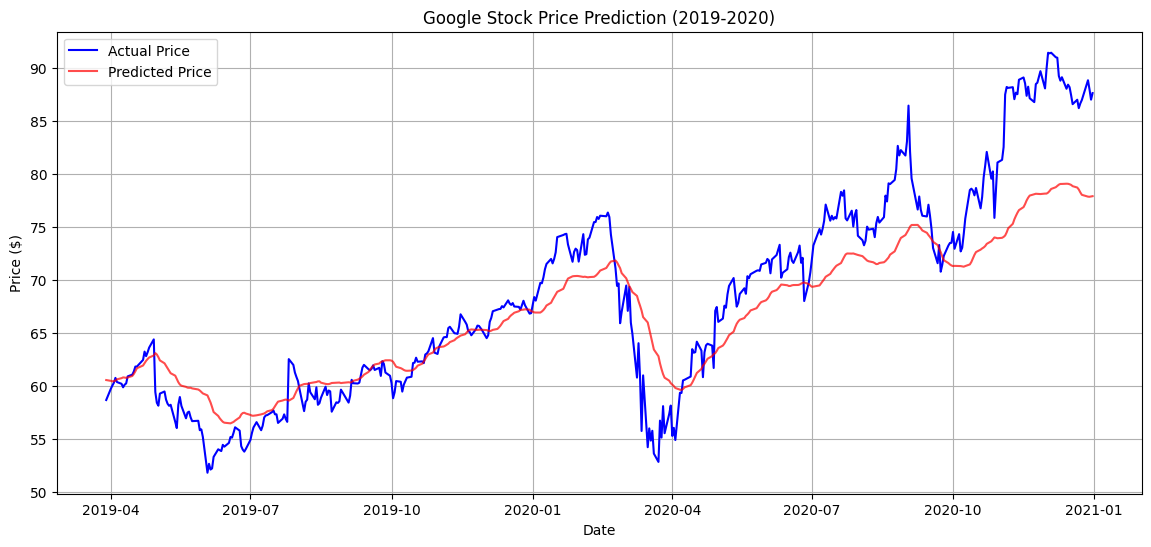

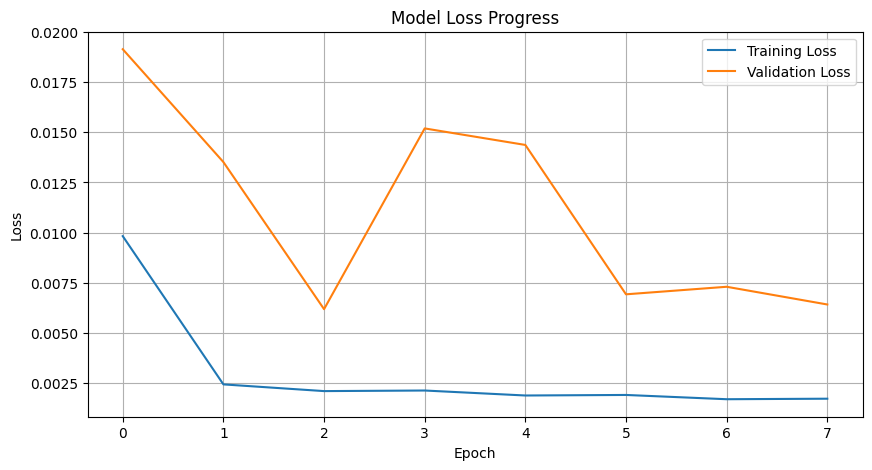

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 1. Load and prepare the data
df = pd.read_csv('GOOG.csv', parse_dates=['Date'], index_col='Date')
df.sort_index(inplace=True)

# 2. Calculate technical indicators
def add_technical_indicators(df):
    # Simple Moving Averages
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['SMA_30'] = df['Close'].rolling(window=30).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()

    # Exponential Moving Averages
    df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

    # RSI
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Drop NA values
    df.dropna(inplace=True)
    return df

df = add_technical_indicators(df)

# 3. Split into train (2004-2018) and test (2019-2020)
train = df.loc['2004-01-01':'2018-12-31']
test = df.loc['2019-01-01':'2020-12-31']

# 4. Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume',
                'SMA_10', 'SMA_30', 'SMA_50', 'EMA_10', 'EMA_20', 'RSI']

train_scaled = scaler.fit_transform(train[feature_cols])
test_scaled = scaler.transform(test[feature_cols])

# 5. Create time sequences
def create_sequences(data, look_back=60):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, :])
        y.append(data[i, feature_cols.index('Close')])  # Predict Close price
    return np.array(X), np.array(y)

look_back = 60
X_train, y_train = create_sequences(train_scaled, look_back)
X_test, y_test = create_sequences(test_scaled, look_back)

# 6. Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# 7. Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

# 8. Make predictions
predictions = model.predict(X_test)

# Create dummy array for inverse transform
dummy_array = np.zeros((len(predictions), len(feature_cols)))
dummy_array[:, feature_cols.index('Close')] = predictions.flatten()
y_pred = scaler.inverse_transform(dummy_array)[:, feature_cols.index('Close')]

dummy_array[:, feature_cols.index('Close')] = y_test.flatten()
y_actual = scaler.inverse_transform(dummy_array)[:, feature_cols.index('Close')]

# 9. Calculate metrics
mse = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_actual, y_pred)
mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
r2 = r2_score(y_actual, y_pred)

print("\nEvaluation Metrics:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²: {r2:.4f}")

# 10. Plot results
plt.figure(figsize=(14, 6))
test_dates = test.index[look_back:]
plt.plot(test_dates, y_actual, label='Actual Price', color='blue')
plt.plot(test_dates, y_pred, label='Predicted Price', color='red', alpha=0.7)
plt.title('Google Stock Price Prediction (2019-2020)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progress')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()